In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from xmitgcm import utils
from xmitgcm import open_mdsdataset
from xgcm import Grid
from xhistogram.xarray import histogram
from dask.diagnostics import ProgressBar

In [2]:
data_dir = "/pool001/xruan/RT_canyon_hydrostatic/diag/"
grid_dir = "/pool001/xruan/RT_canyon_hydrostatic/input/"
ds = open_mdsdataset(
    data_dir, grid_dir = grid_dir, iters="all", prefix=["tracer_inst"],
    ignore_unknown_vars=True, delta_t = 5.
).drop_dims(["Zl", "Zu", "Zp1", "YG", "XG"])
grid = Grid(ds, periodic=['X', 'Y'])
ds['time'] = ds['time'] + np.datetime64('2021-06-27T00:00:00')
ds['TRAC01'].attrs['release'] = '2021-07-01T04:00:00'
time_release = np.datetime64('2021-07-01T04:00:00')

In [3]:
# Reindex and make into small chunks to make xhistogram happy
ds = ds.chunk({'Z':5})
ds = ds.reindex(Z=ds.Z[::-1])

In [4]:
ds = ds.assign_coords({'hours_since_release': ((ds['time'] - time_release)/(3600.*1.e9)).astype("float64")})
ds['hours_since_release'].attrs['long_name'] = 'hours since release'

In [6]:
release_loc = np.array([-11.90375, 54.2185])

locs = [
    release_loc,
    release_loc + np.array([-0.01, 0.01/2.]),
    release_loc + np.array([-0.04, 0.04/2.])
]

In [7]:
with ProgressBar():
    age_spectra = [ds['TRAC01'].interp(Z=[-1820], XC=[l[0]], YC=[l[1]], assume_sorted=True).compute() for l in locs]

[########################################] | 100% Completed |  7min  4.7s
[########################################] | 100% Completed |  7min 38.2s
[########################################] | 100% Completed |  7min 41.1s


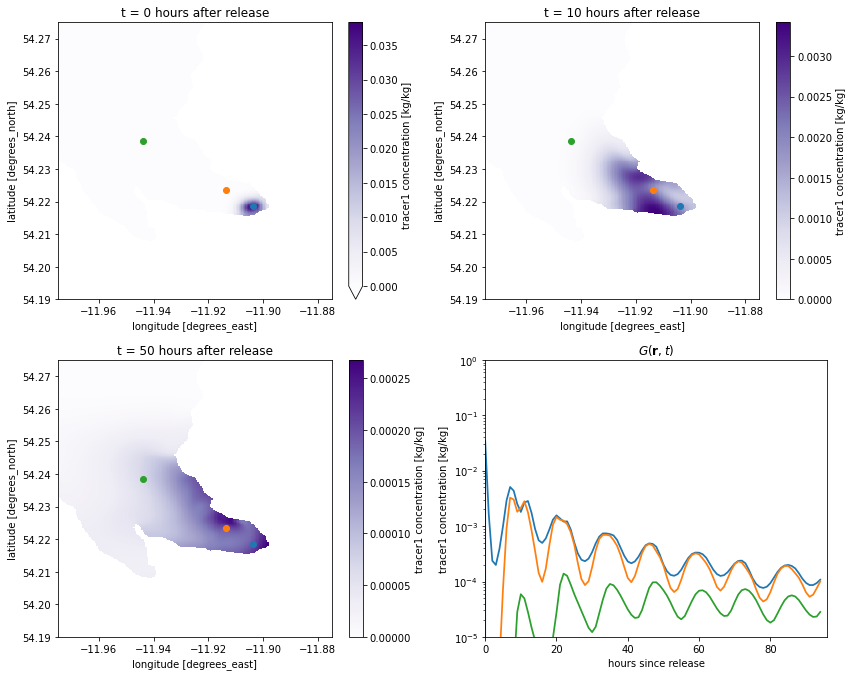

In [20]:
cols = ["C0", "C1", "C2"]

plt.figure(figsize=(12,9.5))
for i, t in enumerate([0, 10, 50]):
    plt.subplot(2,2,i+1)
    vmax = ds['TRAC01'].sel(Z=-1820, time=time_release + np.timedelta64(t,'h'), method="nearest").max().compute()
    ds['TRAC01'].where(ds['hFacC']!=0.).sel(Z=-1820, time=time_release + np.timedelta64(t,'h'), method="nearest").plot(cmap="Purples", vmin=0., vmax=vmax)
    plt.title(f"t = {t} hours after release")
    plt.xlim(-11.975, -11.875)
    plt.ylim(54.19, 54.275)
    
    for j, l in enumerate(locs):
        plt.plot(l[0], l[1], cols[j]+"o")

        
plt.subplot(2,2,4)
for j, l in enumerate(locs):
    age_spectra[j].plot(x="hours_since_release", label=r"\mathbf{r}_{i}", lw=1.75)
    plt.xlim(0, 96)
    plt.ylim(1e-5, 1)
    plt.title(r"$G(\mathbf{r}, t)$")
    plt.yscale("log")
    
plt.tight_layout()